In [10]:
#numpyなどとデータをインポート
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from utils import mnist_reader
from utils.mnist_reader import load_mnist

In [11]:
#データを変数に格納
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

In [12]:
#全てのデータをchainerで扱える型に変更
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

In [13]:
#それぞれの行列の形を出力
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [29]:
#数値に対するlabelを与える
label = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9:'Ankle Boot'}
#出力
label

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle Boot'}

In [15]:
#正規化
#最大値で全ての数を割る
print(X_train.max())
print(X_test.max())
X_train_1 = X_train /255
X_test_1 = X_test /255

255.0
255.0


In [16]:
#形を変化させて4次元にする
X_train = X_train.reshape(60000, 1, 28, 28)
X_test = X_test.reshape(10000, 1, 28, 28)
#次元数を確認
print(X_train.ndim, X_test.ndim)

4 4


In [17]:
#chainerのインポート
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import optimizers

In [18]:
#CNNの構造と計算規則を指定
class CNN(chainer.Chain):
    def __init__(self):
        super().__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(in_channels=1, out_channels=64, ksize=4, stride=1, pad=2)
            self.conv2 = L.Convolution2D(in_channels=64, out_channels=128, ksize=4, stride=1, pad=2)
            self.conv3 = L.Convolution2D(in_channels=None, out_channels=128, ksize=4, stride=1, pad=2) 
            self.fc4 = L.Linear(None, 512)
            self.fc5 = L.Linear(None, 10) 

    def __call__(self, X):
        h = F.relu(F.max_pooling_2d(self.conv1(X), ksize=2)) 
        h = F.relu(F.max_pooling_2d(self.conv2(h), ksize=2)) 
        h = F.relu(F.max_pooling_2d(self.conv3(h), ksize=2)) 
        h = F.relu(self.fc4(h))
        return self.fc5(h)

In [19]:
#chainerのクラスのインポート
from chainer.datasets import tuple_dataset
from chainer.training import extensions
from chainer import optimizers, serializers, training, iterators

In [24]:
# 分類器インスタンスの生成
model = L.Classifier(CNN())

# optimizerの生成
#SGDを利用する
#デフォルトより学習率を低く設定（デフォルト＝0.01)
optimizer = chainer.optimizers.SGD(lr = 0.001) 
# モデルの構造を読み込ませる
optimizer.setup(model)               

# ミニバッチに含まれるサンプル数を指定
batchsize = 100

# epoch数を指定
#fashion-mnistの画像数が多いため計算量が膨大になるので、10でとどめた。
#回数を増やせば精度は単調に上がっていくはず
n_epoch = 10

In [25]:
#X_trainとy_trainをTupleDatasetにまとめていれる
train = tuple_dataset.TupleDataset(X_train,y_train)
#作成したtrainから、batchsize = 100ごとにランダムにデータをサンプリング
train_iter = iterators.SerialIterator(train,batch_size=batchsize,shuffle=True)
#どのデータを参照してどのようなモデルと最適手法（SGD)でパラメータを更新するのかを定義
updater = training.StandardUpdater(train_iter,optimizer)
#学習規則、回数、どこへ報告するかを定義
trainer = training.Trainer(updater,(n_epoch,'epoch'),out = 'result')

In [26]:
#検証のためのtestも用意する。
#trainとおなじようにtestも作成
test = tuple_dataset.TupleDataset(X_test,y_test)
#testデータに対して同じ評価方法で、繰り返しをしないように定義
test_iter = iterators.SerialIterator(test,batch_size=batchsize,shuffle=False,repeat=False)
#どのモデルを利用して、どのデータのテスト精度を出せばよいかを定義
trainer.extend(extensions.Evaluator(test_iter, model))
#ここからは、進捗を表す機能と画像にする機能の拡張
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'main/loss', 'validation/main/accuracy', 'validation/main/loss']))
trainer.extend(extensions.ProgressBar())
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
                          'epoch', file_name='accuracy.png'))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))

In [27]:
trainer.run()

epoch       main/accuracy  main/loss   validation/main/accuracy  validation/main/loss
     total [..................................................]  1.67%
this epoch [########..........................................] 16.67%
       100 iter, 0 epoch / 10 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
     total [#.................................................]  3.33%
this epoch [################..................................] 33.33%
       200 iter, 0 epoch / 10 epochs
   0.65571 iters/sec. Estimated time to finish: 2:27:25.403053.
     total [##................................................]  5.00%
this epoch [#########################.........................] 50.00%
       300 iter, 0 epoch / 10 epochs
   0.65616 iters/sec. Estimated time to finish: 2:24:46.849880.
     total [###...............................................]  6.67%
this epoch [#################################.................] 66.67%
       400 iter, 0 epoch / 10 epochs
   0.66341 it

     total [###########################.......................] 55.00%
this epoch [#########################.........................] 50.00%
      3300 iter, 5 epoch / 10 epochs
   0.63803 iters/sec. Estimated time to finish: 1:10:31.754221.
     total [############################......................] 56.67%
this epoch [#################################.................] 66.67%
      3400 iter, 5 epoch / 10 epochs
   0.63769 iters/sec. Estimated time to finish: 1:07:57.196355.
     total [#############################.....................] 58.33%
this epoch [#########################################.........] 83.33%
      3500 iter, 5 epoch / 10 epochs
   0.63824 iters/sec. Estimated time to finish: 1:05:17.039540.
6           0.905933       0.261494    0.886                     0.320517              
     total [##############################....................] 60.00%
this epoch [..................................................]  0.00%
      3600 iter, 6 epoch / 10 epochs
   0

In [30]:
#PlotReportのグラフを出力する関数を定義
from pylab import box
def show_graph(src):
    img =  plt.imread(src)
    xpixels, ypixels = img.shape[0],img.shape[1]
    dpi = 100
    margin = 0.01
    figsize = (1 + margin) * ypixels / dpi, (1 + margin) * xpixels / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    ax.tick_params(labelbottom="off",bottom="off")
    ax.tick_params(labelleft="off",left="off")

    ax.imshow(img, interpolation='none')
    box("off")
    plt.show()

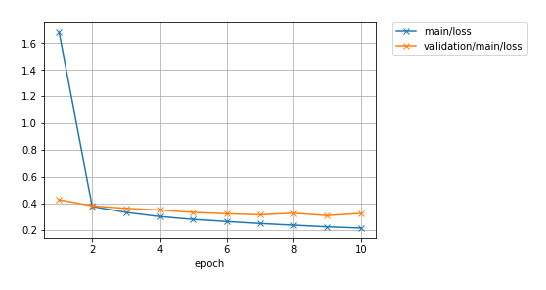

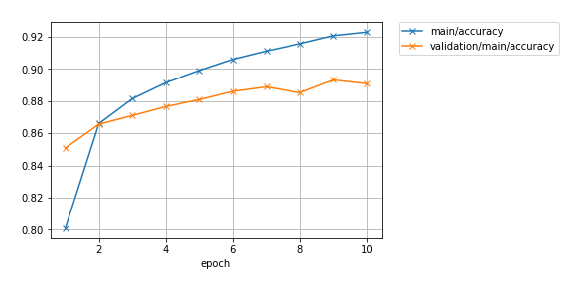

In [31]:
#グラフの出力
show_graph('result/loss.png')
show_graph('result/accuracy.png')
#3回目以降から過学習気味であった。
#この結果から前述した回数を増やせばいいというのは成り立たないことが分かった。
#Layerを変えたり補正

In [33]:
#予測を行う関数を定義
def predict(model, X):
    if len(X.shape) == 3:  # データ数が1の場合は、バッチサイズ分の次元を追加
        pred = model.predictor(X[None, ...]).data.argmax()
    else:  # データ数が2以上の場合はそのまま
        pred = model.predictor(X).data.argmax(axis=1)
    return pred

In [35]:
#前に行ったニューラルネットワークと比較するため同じ評価指標で出力
from sklearn import metrics
print('accuracy: %.3f' % metrics.accuracy_score(y_test, predict(model, X_test)))
print('recall: %.3f' % metrics.recall_score(y_test, predict(model, X_test), average='macro'))
print('precision: %.3f' % metrics.precision_score(y_test, predict(model, X_test), average='macro'))
print('f1_score: %.3f' % metrics.f1_score(y_test, predict(model, X_test), average='macro'))
'''
メモリーエラーが出たので省略する。ニューラルネットワークの時は0.86未満だった。
過学習を起こし始めていたが、グラフから0.89くらいだと思われる。
ニューラルネットワークより高い精度を実現できた。
'''